In [1]:
import unittest
import pandas as pd

from colorama import Fore, Back, Style 

from datetime import datetime

<h1>Import Code to be Tested</h1>

In [2]:
import devanalyst.simulation.statics as S_

import devanalyst.simulation.GenerateTimecards as timecard
from devanalyst.simulation.GenerateTimecards import UserStoriesRepo, UserStory, UserStoryStatus, \
Ticket, TicketsRepo, ScrumTeam, ScrumTeamsRepo, IdCounter, WorkAssignments

from devanalyst.simulation.simulationModels import ModelsConfig, DefaultCostModel, GreedyAllocationModel

importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\statics.ipynb
importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\GenerateTimecards.ipynb
importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\simulationModels.ipynb


In [3]:
import devanalyst.simulation.tests.test_utils as tu_

importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\tests\test_utils.ipynb


<h1>test_uss</h1>
<p>Test User Story Status</p>

In [ ]:
# Implement test logic, and run

# Helper methods to the test
def format_ticket(ticket):
    return ('Ticket:' + ticket.ticketId \
            + ',\n\t\t storyId=' + ticket.userStoryId \
            + ',\n\t\t costToFix=' + str(ticket.costToFix) \
            + ',\n\t\t effortToDate=' + str(ticket.effortToDate) \
            + ',\n\t\t percentAchieved=' + str(ticket.percentAchieved))
                
def format_tickets(tickets):
    output = ''
    for ticket in tickets:
        output = output + '\n\t\t{' + format_ticket(ticket) + '}'
    return output
            
def format_uss(uss):
    return ('\n *** USS:' + uss.userStoryId \
            + '\n\t achieved=' + str(uss.percentAchieved) \
            + ',\n\t planned=' + str(uss.planned) \
            + ',\n\t sprintPlanned=' + str(uss.sprintPlanned) \
            + ',\n\t tickets=' + format_tickets(uss.pendingTickets))

def format_item(item, item_label, sprint, timeInSprint):
    return ('\n *** ' + item_label + ' at ' + timeInSprint + ' of sprint' + str(sprint) + ': ' \
            + '\n\t userStoryId=' + str(item.userStoryId) \
            + ',\n\t taskType=' + str(item.taskType) \
            + ',\n\t ticketId=' + str(item.ticketId) \
            + ',\n\t estimate=' + '{0:.2f}'.format(item.estimate) \
            + ',\n\t percentAchieved=' + str(item.percentAchieved)  \
            + ',\n\t sprintPlanned=' + str(item.sprintPlanned))

# Test logic
def test_uss():
    output = '' 
    repo = UserStoriesRepo([UserStory('Story A', 25, 'Joe Developer', 'Amy PM'), \
                            UserStory('Story B', 17, 'Alex Developer', 'Kate PM')])
    uss = UserStoryStatus('Story B', 0.0)
    uss.planned = True
    uss.sprintPlanned = 1
    output = output + (format_uss(uss))
    item = uss.generateWorkItems(repo)[0]
    output = output + (format_item(item, 'Item#1', 1, 'start'))
    item.percentAchieved = 0.7
    newTickets = [Ticket('Bug 100','Story B', 4), Ticket('Bug 101','Story B', 1.5)]
    bugRepo = TicketsRepo(newTickets)
    output = output + (format_item(item, 'Item#1', 1, 'end'))
    uss.updateStatus([item], newTickets, bugRepo)
    uss.sprintPlanned = 2
    output = output + (format_uss(uss))

    items = uss.generateWorkItems(repo)
    item=items[0]
    output = output + (format_item(item, 'Item#1', 2, 'start'))
    item=items[1]
    output = output + (format_item(item, 'Item#2', 2, 'start'))
    item=items[2]
    output = output + (format_item(item, 'Item#3', 2, 'start'))
    items[0].percentAchieved = 0.9
    items[1].percentAchieved = 1.0
    items[2].percentAchieved = 0.5
    item=items[0]
    item=items[0]
    item=items[1]
    output = output + (format_item(item, 'Item#2', 2, 'end'))
    item=items[2]
    output = output + (format_item(item, 'Item#3', 2, 'end'))
    uss.updateStatus(items, [], bugRepo)
    output = output + (format_uss(uss))
    return output

# Run the test
test_uss_ACTUAL = test_uss()

In [ ]:
# Uncomment to print a string output one can copy and paste into test_uss_EXPECTED
#test_uss_ACTUAL

In [ ]:
# Set expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
test_uss_EXPECTED = '\n *** USS:Story B\n\t achieved=0.0,\n\t planned=True,\n\t sprintPlanned=1,\n\t tickets=\n *** Item#1 at start of sprint1: \n\t userStoryId=Story B,\n\t taskType=UNFINISHED_STORIES,\n\t ticketId=None,\n\t estimate=17.00,\n\t percentAchieved=0.0,\n\t sprintPlanned=1\n *** Item#1 at end of sprint1: \n\t userStoryId=Story B,\n\t taskType=UNFINISHED_STORIES,\n\t ticketId=None,\n\t estimate=17.00,\n\t percentAchieved=0.7,\n\t sprintPlanned=1\n *** USS:Story B\n\t achieved=0.7,\n\t planned=True,\n\t sprintPlanned=2,\n\t tickets=\n\t\t{Ticket:Bug 100,\n\t\t storyId=Story B,\n\t\t costToFix=4,\n\t\t effortToDate=0.0,\n\t\t percentAchieved=0.0}\n\t\t{Ticket:Bug 101,\n\t\t storyId=Story B,\n\t\t costToFix=1.5,\n\t\t effortToDate=0.0,\n\t\t percentAchieved=0.0}\n *** Item#1 at start of sprint2: \n\t userStoryId=Story B,\n\t taskType=UNFINISHED_STORIES,\n\t ticketId=None,\n\t estimate=5.10,\n\t percentAchieved=0.0,\n\t sprintPlanned=2\n *** Item#2 at start of sprint2: \n\t userStoryId=Story B,\n\t taskType=BUGS_ON_UNFINISHED_STORIES,\n\t ticketId=Bug 100,\n\t estimate=2.00,\n\t percentAchieved=0.0,\n\t sprintPlanned=2\n *** Item#3 at start of sprint2: \n\t userStoryId=Story B,\n\t taskType=BUGS_ON_UNFINISHED_STORIES,\n\t ticketId=Bug 101,\n\t estimate=2.00,\n\t percentAchieved=0.0,\n\t sprintPlanned=2\n *** Item#2 at end of sprint2: \n\t userStoryId=Story B,\n\t taskType=BUGS_ON_UNFINISHED_STORIES,\n\t ticketId=Bug 100,\n\t estimate=2.00,\n\t percentAchieved=1.0,\n\t sprintPlanned=2\n *** Item#3 at end of sprint2: \n\t userStoryId=Story B,\n\t taskType=BUGS_ON_UNFINISHED_STORIES,\n\t ticketId=Bug 101,\n\t estimate=2.00,\n\t percentAchieved=0.5,\n\t sprintPlanned=2\n *** USS:Story B\n\t achieved=0.97,\n\t planned=True,\n\t sprintPlanned=2,\n\t tickets=\n\t\t{Ticket:Bug 101,\n\t\t storyId=Story B,\n\t\t costToFix=1.5,\n\t\t effortToDate=2.0,\n\t\t percentAchieved=0.5}'

tu_.EXPECTED['uss'] = test_uss_EXPECTED
tu_.ACTUAL['uss'] = test_uss_ACTUAL
tu_.testOK('uss')

In [ ]:
# Print ACTUAL output
print(Back.BLUE + Fore.WHITE + '--------------------- ACTUAL -------------------------', \
      Back.RESET + Fore.BLUE + '\n' + test_uss_ACTUAL) 

In [ ]:
# Print EXPECTED output
print(Back.GREEN + Fore.WHITE + '--------------------- EXPECTED -----------------------', \
      Back.RESET + Fore.GREEN + '\n' + test_uss_EXPECTED) 

<h1>test_createTeams</h1>

In [ ]:
# Implement test logic, and run

teams_df = timecard.createTeamsDF(tu_.DEV_DF, tu_.PM_DF)

object_cols = ['Scrum Team'] # Need to drop these since they print always-chaning memory address + can't save it in EXPECTED
test_createTeams_ACTUAL = teams_df.drop(object_cols, axis='columns')

In [ ]:
# Uncomment to update expected output to match the actual one
#tu_.createExpectedOutput(test_createTeams_ACTUAL, 'test_createTeams')

In [ ]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
list_cols = ['Developers', 'Product Managers', 'Areas of Responsibility']
test_createTeams_EXPECTED = tu_.loadExpectedOutput('test_createTeams', list_cols)

tu_.EXPECTED['createTeams'] = test_createTeams_EXPECTED
tu_.ACTUAL['createTeams'] = test_createTeams_ACTUAL
tu_.testOK('createTeams')

In [ ]:
test_createTeams_ACTUAL

In [ ]:
test_createTeams_EXPECTED

<h1>test_userStoryCreate</h1>
<p>This test has multiple views, each of which is checked separately</p>
<li>test_userStoryCreate_stories
<li>test_userStoryCreate_estimates
<li>test_userStoryCreate_crossCheck
<li>test_userStoryCreate_workload

In [ ]:
# Implement test logic, and run it

#Test logic
def test_userStoryCreate():
    output = {}
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10
    NUMBER_OF_SPRINTS = 25

    # Configure models
    modelsConfig = ModelsConfig([DefaultCostModel()], [], GreedyAllocationModel(SPRINT_DURATION)) 
    modelsConfig.random.reset(271)

    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)
        
    grouped_estimates_df = stories_df.groupby([ 'Scrum Team', 'Developer'])['Estimate'].sum()
    workload_df = stories_df.groupby([ 'Scrum Team'])['User Story Id'].count()
    #workload_count_df = workload_df.count()
    
    avg_estimates_df = grouped_estimates_df.unstack().apply(lambda x: x.mean(), axis='columns')

    # Reset index to match the way how EXPECTED will be saved as a CSV file
    estimates_df      = grouped_estimates_df.reset_index()
    workload_df       = workload_df.reset_index()
    avg_estimates_df= avg_estimates_df.reset_index()
    
    # The unstacking above created an column with a number as the column name, 0. That will not match once expected output is saved
    # and reloaded, as it will come back as the string '0'. So rename that column to avoid spurious test failures
    avg_estimates_df = avg_estimates_df.rename(index=str, columns={0: 'Avg'})
    
    # Because of the manipulations, the index has changed and that will cause mistaches with the EXPECTED loaded from 
    # CSV. So re-index
    avg_estimates_df.index = pd.RangeIndex(start=0, stop=avg_estimates_df.index.size, step=1)
    
    crosscheck = [len(teams_df['Scrum Team'][0].backlog.pendingUserStories), 
                  len(teams_df['Scrum Team'][1].backlog.pendingUserStories),
                  len(teams_df['Scrum Team'][2].backlog.pendingUserStories), 
                  len(teams_df['Scrum Team'][3].backlog.pendingUserStories)]
    crosscheck_df = pd.DataFrame({'Team idx': [0,1,2,3], 'Backlog size': crosscheck})
    
    output['stories_df'] = stories_df
    output['estimates_df'] = estimates_df
    output['workload_df'] = workload_df
    output['crosscheck_df'] = crosscheck_df
    output['avg_estimates_df'] = avg_estimates_df

    return output

# Run the test
test_userStoryCreate_ACTUAL = test_userStoryCreate()

In [ ]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_userStoryCreate_EXPECTED():
    tu_.createExpectedOutput(test_userStoryCreate_ACTUAL['stories_df'],        'test_userStoryCreate.stories_df')
    tu_.createExpectedOutput(test_userStoryCreate_ACTUAL['estimates_df'],      'test_userStoryCreate.estimates_df')
    tu_.createExpectedOutput(test_userStoryCreate_ACTUAL['workload_df'],       'test_userStoryCreate.workload_df')
    tu_.createExpectedOutput(test_userStoryCreate_ACTUAL['crosscheck_df'],     'test_userStoryCreate.crosscheck_df')
    tu_.createExpectedOutput(test_userStoryCreate_ACTUAL['avg_estimates_df'],  'test_userStoryCreate.avg_estimates_df')

# Uncomment to update expected output to match the actual one, and then put the comment back
#create_userStoryCreate_EXPECTED()

In [ ]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK

test_userStoryCreate_EXPECTED = {}

test_userStoryCreate_EXPECTED['stories_df']         = tu_.loadExpectedOutput('test_userStoryCreate.stories_df')
test_userStoryCreate_EXPECTED['estimates_df']       = tu_.loadExpectedOutput('test_userStoryCreate.estimates_df')
test_userStoryCreate_EXPECTED['workload_df']        = tu_.loadExpectedOutput('test_userStoryCreate.workload_df')
test_userStoryCreate_EXPECTED['crosscheck_df']      = tu_.loadExpectedOutput('test_userStoryCreate.crosscheck_df')
test_userStoryCreate_EXPECTED['avg_estimates_df']   = tu_.loadExpectedOutput('test_userStoryCreate.avg_estimates_df')

# Rounding inaccuracies in saving and loading CSV will create an artificial mismatch between ACTUAL and EXPECTED
# So round EXPECTED and ACTUAL to 6 decimal places for the sensitive fields
rounded = test_userStoryCreate_EXPECTED['avg_estimates_df']['Avg'].apply(lambda x: round(x, 6)) # Round to 6 decimal places
test_userStoryCreate_EXPECTED['avg_estimates_df']['Avg'] = rounded
rounded = test_userStoryCreate_ACTUAL['avg_estimates_df']['Avg'].apply(lambda x: round(x, 6)) # Round to 6 decimal places
test_userStoryCreate_ACTUAL['avg_estimates_df']['Avg'] = rounded

tu_.EXPECTED['test_userStoryCreate.stories_df']         = test_userStoryCreate_EXPECTED['stories_df']
tu_.EXPECTED['test_userStoryCreate.estimates_df']       = test_userStoryCreate_EXPECTED['estimates_df']
tu_.EXPECTED['test_userStoryCreate.workload_df']        = test_userStoryCreate_EXPECTED['workload_df']
tu_.EXPECTED['test_userStoryCreate.crosscheck_df']      = test_userStoryCreate_EXPECTED['crosscheck_df']
tu_.EXPECTED['test_userStoryCreate.avg_estimates_df']   = test_userStoryCreate_EXPECTED['avg_estimates_df']

tu_.ACTUAL['test_userStoryCreate.stories_df']           = test_userStoryCreate_ACTUAL['stories_df']
tu_.ACTUAL['test_userStoryCreate.estimates_df']         = test_userStoryCreate_ACTUAL['estimates_df']
tu_.ACTUAL['test_userStoryCreate.workload_df']          = test_userStoryCreate_ACTUAL['workload_df']
tu_.ACTUAL['test_userStoryCreate.crosscheck_df']        = test_userStoryCreate_ACTUAL['crosscheck_df']
tu_.ACTUAL['test_userStoryCreate.avg_estimates_df']     = test_userStoryCreate_ACTUAL['avg_estimates_df']

tu_.testOK('test_userStoryCreate.stories_df'), \
tu_.testOK('test_userStoryCreate.estimates_df'), \
tu_.testOK('test_userStoryCreate.workload_df'), \
tu_.testOK('test_userStoryCreate.crosscheck_df'), \
tu_.testOK('test_userStoryCreate.avg_estimates_df')

In [ ]:
test_userStoryCreate_ACTUAL['stories_df']

In [ ]:
test_userStoryCreate_EXPECTED['stories_df']

In [ ]:
test_userStoryCreate_ACTUAL['estimates_df']

In [ ]:
test_userStoryCreate_EXPECTED['estimates_df']

In [ ]:
test_userStoryCreate_ACTUAL['workload_df']

In [ ]:
test_userStoryCreate_EXPECTED['workload_df']

In [ ]:
test_userStoryCreate_ACTUAL['crosscheck_df']

In [ ]:
test_userStoryCreate_EXPECTED['crosscheck_df']

In [ ]:
test_userStoryCreate_ACTUAL['avg_estimates_df']

In [ ]:
test_userStoryCreate_EXPECTED['avg_estimates_df']

<h1>test_WorkAssignments</h1>

In [ ]:
# Implement test logic, and run it

#Test logic
def test_WorkAssignments():
    output = {}
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10
    #NUMBER_OF_SPRINTS = 25

    # Configure models
    modelsConfig = ModelsConfig([DefaultCostModel()], [], GreedyAllocationModel(SPRINT_DURATION)) 
    modelsConfig.random.reset(271)

    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)

    
    #timecard.RANDOM.reset(271) # Set seed so output is the same even if logic invokes random methods
    #teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = initTestData(DEV_DF, PM_DF, 125)

    teamId0 = teams_df['Scrum Team'][0].teamId
    work = WorkAssignments(teamId0, teamsRepo, storiesRepo, sprint=1)
    initial_df = work.committedTime(10)
    # Test re-assigning of work
    item = work.allocations[S_.UNPLANNED][S_.OWNER_TBD][S_.UNFINISHED_STORIES][25]
    work.reAssign(item, 'Bruno Studley', S_.CURRENT_SPRINT)
    final_df = work.committedTime(10)
    
    output['Initial'] = initial_df
    output['Final'] = final_df

    return output
    
# Run the test
test_WorkAssignments_ACTUAL = test_WorkAssignments()

In [ ]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_WorkAssignments_EXPECTED():
    tu_.createExpectedOutput(test_WorkAssignments_ACTUAL['Initial'],        'test_WorkAssignments.Initial')
    tu_.createExpectedOutput(test_WorkAssignments_ACTUAL['Final'],          'test_WorkAssignments.Final')

# Uncomment to update expected output to match the actual one, and then put the comment back
#create_WorkAssignments_EXPECTED()

In [ ]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
test_WorkAssignments_EXPECTED = {}

test_WorkAssignments_EXPECTED['Initial']         = tu_.loadExpectedOutput('test_WorkAssignments.Initial')
test_WorkAssignments_EXPECTED['Final']           = tu_.loadExpectedOutput('test_WorkAssignments.Final')

tu_.EXPECTED['test_WorkAssignments.Initial']         = test_WorkAssignments_EXPECTED['Initial']
tu_.EXPECTED['test_WorkAssignments.Final']           = test_WorkAssignments_EXPECTED['Final']

tu_.ACTUAL['test_WorkAssignments.Initial']           = test_WorkAssignments_ACTUAL['Initial']
tu_.ACTUAL['test_WorkAssignments.Final']             = test_WorkAssignments_ACTUAL['Final']

tu_.testOK('test_WorkAssignments.Initial'), \
tu_.testOK('test_WorkAssignments.Final'), \


In [ ]:
test_WorkAssignments_ACTUAL['Initial']

In [ ]:
test_WorkAssignments_EXPECTED['Initial']

In [ ]:
test_WorkAssignments_ACTUAL['Final']

In [ ]:
test_WorkAssignments_EXPECTED['Final']

<h1>test_oneSprint</h1>

In [ ]:
# Implement test logic, and run it

#Test logic
def test_oneSprint():    
    output = {}

    # Choose what to work on at the start of a sprint.
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10

    # Configure models
    modelsConfig = ModelsConfig([DefaultCostModel()], [], GreedyAllocationModel(SPRINT_DURATION))
    modelsConfig.random.reset(271)
    
    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)

    # Select a team
    teamId = teams_df['Scrum Team'][0].teamId
    
    work = timecard.chooseWhatToDoInSprint(teamId, teamsRepo, storiesRepo, SPRINT_DURATION, modelsConfig, sprint=1)
    start_committed_df = work.committedTime(SPRINT_DURATION)
    start_tasks_df = work.committedTasks()
    
    # Deliver what the sprint actually accomplished, including ingest of defects arriving during sprint
    timecard.deliverSprint(teamId, teamsRepo, ticketsRepo, storiesRepo, work, SPRINT_DURATION, modelsConfig) # mutates work
    inflow = timecard.inflowOfTickets(teamId, teamsRepo, ticketsRepo, storiesRepo)
    end_committed_df = work.committedTime(0) # Sprint is over, so sprint capacity parameter is 0
    
    # Test continued
    timecard.updateBacklogAfterSprint(teamId, teamsRepo, ticketsRepo, storiesRepo, work, inflow)
    end_tasks_df = work.committedTasks()
    
    output['Start_Committed'] = start_committed_df
    output['Start_Tasks'] = start_tasks_df
    output['End_Committed'] = end_committed_df
    output['End_Tasks'] = end_tasks_df
    return output

# Run the test
test_oneSprint_ACTUAL = test_oneSprint()

In [ ]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_oneSprint_EXPECTED():
    tu_.createExpectedOutput(test_oneSprint_ACTUAL['Start_Committed'],    'test_oneSprint.Start_Committed')
    tu_.createExpectedOutput(test_oneSprint_ACTUAL['Start_Tasks'],        'test_oneSprint.Start_Tasks')
    tu_.createExpectedOutput(test_oneSprint_ACTUAL['End_Committed'],      'test_oneSprint.End_Committed')
    tu_.createExpectedOutput(test_oneSprint_ACTUAL['End_Tasks'],          'test_oneSprint.End_Tasks')

# Uncomment to update expected output to match the actual one, and then put the comment back
#create_oneSprint_EXPECTED()

In [ ]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
test_oneSprint_EXPECTED = {}

test_oneSprint_EXPECTED['Start_Committed']      = tu_.loadExpectedOutput('test_oneSprint.Start_Committed')
test_oneSprint_EXPECTED['Start_Tasks']          = tu_.loadExpectedOutput('test_oneSprint.Start_Tasks')
test_oneSprint_EXPECTED['End_Committed']        = tu_.loadExpectedOutput('test_oneSprint.End_Committed')
test_oneSprint_EXPECTED['End_Tasks']            = tu_.loadExpectedOutput('test_oneSprint.End_Tasks')

# Rounding inaccuracies in saving and loading CSV will create an artificial mismatch between ACTUAL and EXPECTED
# So round EXPECTED and ACTUAL to 6 decimal places for sensitive fields (any float)
sensitive_fields = ['Rejects (days)', 'Debugging (days)', 'Implementation (days)', 'Bandwidth',\
                    'NEXT SPRINT (days)', 'NEXT SPRINT Bandwidth']
testlets = ['Start_Committed', 'End_Committed']
for field in sensitive_fields:
    for testlet in testlets:
        rounded = test_oneSprint_EXPECTED[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_oneSprint_EXPECTED[testlet][field] = rounded
        rounded = test_oneSprint_ACTUAL[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_oneSprint_ACTUAL[testlet][field] = rounded
sensitive_fields = ['Original Estimate', 'Effort Spent', 'Effort Remaining', 'Percent Achieved']
testlets = ['Start_Tasks', 'End_Tasks']
for field in sensitive_fields:
    for testlet in testlets:
        rounded = test_oneSprint_EXPECTED[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_oneSprint_EXPECTED[testlet][field] = rounded
        rounded = test_oneSprint_ACTUAL[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_oneSprint_ACTUAL[testlet][field] = rounded

tu_.EXPECTED['test_oneSprint.Start_Committed']      = test_oneSprint_EXPECTED['Start_Committed']
tu_.EXPECTED['test_oneSprint.Start_Tasks']          = test_oneSprint_EXPECTED['Start_Tasks']
tu_.EXPECTED['test_oneSprint.End_Committed']        = test_oneSprint_EXPECTED['End_Committed']
tu_.EXPECTED['test_oneSprint.End_Tasks']            = test_oneSprint_EXPECTED['End_Tasks']

tu_.ACTUAL['test_oneSprint.Start_Committed']        = test_oneSprint_ACTUAL['Start_Committed']
tu_.ACTUAL['test_oneSprint.Start_Tasks']            = test_oneSprint_ACTUAL['Start_Tasks']
tu_.ACTUAL['test_oneSprint.End_Committed']          = test_oneSprint_ACTUAL['End_Committed']
tu_.ACTUAL['test_oneSprint.End_Tasks']              = test_oneSprint_ACTUAL['End_Tasks']

tu_.testOK('test_oneSprint.Start_Committed'), \
tu_.testOK('test_oneSprint.Start_Tasks'), \
tu_.testOK('test_oneSprint.End_Committed'), \
tu_.testOK('test_oneSprint.End_Tasks'), \

In [ ]:
test_oneSprint_ACTUAL['Start_Committed']

In [ ]:
test_oneSprint_EXPECTED['Start_Committed']

In [ ]:
test_oneSprint_ACTUAL['Start_Tasks']

In [ ]:
test_oneSprint_EXPECTED['Start_Tasks']

In [ ]:
test_oneSprint_ACTUAL['End_Committed']

In [ ]:
test_oneSprint_EXPECTED['End_Committed']

In [ ]:
test_oneSprint_ACTUAL['End_Tasks']

In [ ]:
test_oneSprint_EXPECTED['End_Tasks']

<h1>test_multipleSprints</h1>

In [ ]:
# Implement test logic, and run it

#Test logic
def test_multipleSprints():
    output = {}
    # Test many sprints into the future, to see if eventually people have extra time and start using that extra time
    # in the current sprint to get a head start on tasks for the next sprint
    SPRINT_DURATION = 10
    NUMBER_OF_SPRINTS = 15 
    
    # Configure models
    modelsConfig = ModelsConfig([DefaultCostModel()], [], GreedyAllocationModel(SPRINT_DURATION)) 
    modelsConfig.random.reset(271)
    
    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             125, SPRINT_DURATION, modelsConfig)
    
    # Select a team
    teamId = teams_df['Scrum Team'][0].teamId
    


    work = None
    for i in range(NUMBER_OF_SPRINTS):
        work = timecard.chooseWhatToDoInSprint(teamId, teamsRepo, storiesRepo, SPRINT_DURATION, modelsConfig, sprint=i+1)
        if (i== NUMBER_OF_SPRINTS -1):
            break
        timecard.deliverSprint(teamId, teamsRepo, ticketsRepo, storiesRepo, work, SPRINT_DURATION, \
                              modelsConfig) # mutates 'work'
        inflow = timecard.inflowOfTickets(teamId, teamsRepo, ticketsRepo, storiesRepo)
        timecard.updateBacklogAfterSprint(teamId, teamsRepo, ticketsRepo, storiesRepo, work, inflow) # Does not mutate 'work'
    
    # Work Assignments at the start of the last sprint. Should see some "looking ahead" tasks, i.e., tasks that would
    # normally be done in the next sprint but are started in this sprint since we have time leftover from this sprint's 
    # deliverables
    last = work
    start_committed_df = last.committedTime(10)
    start_tasks_df     = last.committedTasks()
    
    # Finish this last sprint and confirm we spent time in some of the deliveries for the next sprint (i.e., that we
    # were "looking ahead")
    timecard.deliverSprint(teamId, teamsRepo, ticketsRepo, storiesRepo, last, 10, modelsConfig)
    end_committed_df = last.committedTime(0)
    end_tasks_df     =last.committedTasks()
    
    output['start_committed']   = start_committed_df
    output['start_tasks']       = start_tasks_df
    output['end_committed']     = end_committed_df
    output['end_tasks']         = end_tasks_df

    return output

# Run the test
test_multipleSprints_ACTUAL = test_multipleSprints()

In [ ]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_multipleSprints_EXPECTED():
    tu_.createExpectedOutput(test_multipleSprints_ACTUAL['start_committed'],    'test_multipleSprints.start_committed')
    tu_.createExpectedOutput(test_multipleSprints_ACTUAL['start_tasks'],        'test_multipleSprints.start_tasks')
    tu_.createExpectedOutput(test_multipleSprints_ACTUAL['end_committed'],      'test_multipleSprints.end_committed')
    tu_.createExpectedOutput(test_multipleSprints_ACTUAL['end_tasks'],          'test_multipleSprints.end_tasks')

# Uncomment to update expected output to match the actual one, and then put the comment back
#create_multipleSprints_EXPECTED()

In [ ]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
test_multipleSprints_EXPECTED = {}

test_multipleSprints_EXPECTED['start_committed']    = tu_.loadExpectedOutput('test_multipleSprints.start_committed')
test_multipleSprints_EXPECTED['start_tasks']        = tu_.loadExpectedOutput('test_multipleSprints.start_tasks')
test_multipleSprints_EXPECTED['end_committed']      = tu_.loadExpectedOutput('test_multipleSprints.end_committed')
test_multipleSprints_EXPECTED['end_tasks']          = tu_.loadExpectedOutput('test_multipleSprints.end_tasks')

# Rounding inaccuracies in saving and loading CSV will create an artificial mismatch between ACTUAL and EXPECTED
# So round EXPECTED and ACTUAL to 6 decimal places for sensitive fields (any float)
sensitive_fields = ['Rejects (days)', 'Debugging (days)', 'Implementation (days)', 'Bandwidth',\
                    'NEXT SPRINT (days)', 'NEXT SPRINT Bandwidth']
testlets = ['start_committed', 'end_committed']
for field in sensitive_fields:
    for testlet in testlets:
        rounded = test_multipleSprints_EXPECTED[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_multipleSprints_EXPECTED[testlet][field] = rounded
        rounded = test_multipleSprints_ACTUAL[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_multipleSprints_ACTUAL[testlet][field] = rounded
sensitive_fields = ['Original Estimate', 'Effort Spent', 'Effort Remaining', 'Percent Achieved']
testlets = ['start_tasks', 'end_tasks']
for field in sensitive_fields:
    for testlet in testlets:
        rounded = test_multipleSprints_EXPECTED[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_multipleSprints_EXPECTED[testlet][field] = rounded
        rounded = test_multipleSprints_ACTUAL[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_multipleSprints_ACTUAL[testlet][field] = rounded

tu_.EXPECTED['test_multipleSprints.start_committed']    = test_multipleSprints_EXPECTED['start_committed']
tu_.EXPECTED['test_multipleSprints.start_tasks']        = test_multipleSprints_EXPECTED['start_tasks']
tu_.EXPECTED['test_multipleSprints.end_committed']      = test_multipleSprints_EXPECTED['end_committed']
tu_.EXPECTED['test_multipleSprints.end_tasks']          = test_multipleSprints_EXPECTED['end_tasks']

tu_.ACTUAL['test_multipleSprints.start_committed']      = test_multipleSprints_ACTUAL['start_committed']
tu_.ACTUAL['test_multipleSprints.start_tasks']          = test_multipleSprints_ACTUAL['start_tasks']
tu_.ACTUAL['test_multipleSprints.end_committed']        = test_multipleSprints_ACTUAL['end_committed']
tu_.ACTUAL['test_multipleSprints.end_tasks']            = test_multipleSprints_ACTUAL['end_tasks']

tu_.testOK('test_multipleSprints.start_committed'), \
tu_.testOK('test_multipleSprints.start_tasks'), \
tu_.testOK('test_multipleSprints.end_committed'), \
tu_.testOK('test_multipleSprints.end_tasks'), \

In [ ]:
test_multipleSprints_ACTUAL['start_committed']

In [ ]:
test_multipleSprints_EXPECTED['start_committed']

In [ ]:
test_multipleSprints_ACTUAL['start_tasks']

In [ ]:
test_multipleSprints_EXPECTED['start_tasks']

In [ ]:
test_multipleSprints_ACTUAL['end_committed']

In [ ]:
test_multipleSprints_EXPECTED['end_committed']

In [ ]:
test_multipleSprints_ACTUAL['end_tasks']

In [ ]:
test_multipleSprints_EXPECTED['end_tasks']

<h1>test_releaseCycle</h1>

In [4]:
# Implement test logic, and run it

# Test logic
def test_releaseCycle():
    output = {}
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10
    NUMBER_OF_SPRINTS = 25

    # Configure models
    modelsConfig = ModelsConfig([DefaultCostModel()], [], GreedyAllocationModel(SPRINT_DURATION)) 
    modelsConfig.random.reset(271)

    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)
    


    entries_df, worksheets, log = timecard.runReleaseCycle(teamsRepo, ticketsRepo, storiesRepo, datetime(2018, 1, 15), \
                                                   SPRINT_DURATION, NUMBER_OF_SPRINTS, modelsConfig)    
    
    anton_df = entries_df[entries_df['Developer'] == 'Anton Easterday']
    glenna_df = entries_df[entries_df['Developer'] == 'Glenna Mcghie']
        
    burnout_df = timecard.releaseBurnout(entries_df)
    
    output['Entries'] = entries_df
    output['Anton'] = anton_df
    output['Glenna'] = glenna_df
    output['Burnout'] = burnout_df
    output['log'] = log

    return output

# Run the test
test_releaseCycle_ACTUAL = test_releaseCycle()

In [5]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_releaseCycle_EXPECTED():
    tu_.createExpectedOutput(test_releaseCycle_ACTUAL['Entries'],    'test_releaseCycle.Entries')
    tu_.createExpectedOutput(test_releaseCycle_ACTUAL['Anton'],      'test_releaseCycle.Anton')
    tu_.createExpectedOutput(test_releaseCycle_ACTUAL['Glenna'],     'test_releaseCycle.Glenna')
    tu_.createExpectedOutput(test_releaseCycle_ACTUAL['Burnout'],    'test_releaseCycle.Burnout')

# Uncomment to update expected output to match the actual one, and then put the comment back
#create_releaseCycle_EXPECTED()

In [6]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
test_releaseCycle_EXPECTED = {}

test_releaseCycle_EXPECTED['Entries']      = tu_.loadExpectedOutput('test_releaseCycle.Entries')
test_releaseCycle_EXPECTED['Anton']        = tu_.loadExpectedOutput('test_releaseCycle.Anton')
test_releaseCycle_EXPECTED['Glenna']       = tu_.loadExpectedOutput('test_releaseCycle.Glenna')
test_releaseCycle_EXPECTED['Burnout']      = tu_.loadExpectedOutput('test_releaseCycle.Burnout')

# Rounding inaccuracies in saving and loading CSV will create an artificial mismatch between ACTUAL and EXPECTED
# So round EXPECTED and ACTUAL to 6 decimal places for sensitive fields (any float)
sensitive_fields = ['Time Spent']
testlets = ['Entries', 'Anton', 'Glenna']
for field in sensitive_fields:
    for testlet in testlets:
        rounded = test_releaseCycle_EXPECTED[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_releaseCycle_EXPECTED[testlet][field] = rounded
        rounded = test_releaseCycle_ACTUAL[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_releaseCycle_ACTUAL[testlet][field] = rounded
sensitive_fields = ['Effort']
testlets = ['Burnout']
for field in sensitive_fields:
    for testlet in testlets:
        rounded = test_releaseCycle_EXPECTED[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_releaseCycle_EXPECTED[testlet][field] = rounded
        rounded = test_releaseCycle_ACTUAL[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_releaseCycle_ACTUAL[testlet][field] = rounded
        
# Dates are loaded as strings, not pd.Timestamps, so to avoid spurious mismatches between ACTUAL (which represents dates
# as pd.Timestamps) and EXPECTED, convert the EXPECTED dates into pd.Timestamps
d = test_releaseCycle_EXPECTED['Entries']['Date']
test_releaseCycle_EXPECTED['Entries']['Date'] = d.apply(lambda x: pd.Timestamp(datetime.strptime(x, '%Y-%m-%d')))
d = test_releaseCycle_EXPECTED['Anton']['Date']
test_releaseCycle_EXPECTED['Anton']['Date'] = d.apply(lambda x: pd.Timestamp(datetime.strptime(x, '%Y-%m-%d')))
d = test_releaseCycle_EXPECTED['Glenna']['Date']
test_releaseCycle_EXPECTED['Glenna']['Date'] = d.apply(lambda x: pd.Timestamp(datetime.strptime(x, '%Y-%m-%d')))

# For output that was filtered (i.e., a subset of rows from a dataframe), the CSV files messes up the index so fix this 
# to avoid spurious mismatches between ACTUAL and EXPECTED
test_releaseCycle_EXPECTED['Anton'].index = test_releaseCycle_ACTUAL['Anton'].index
test_releaseCycle_EXPECTED['Glenna'].index = test_releaseCycle_ACTUAL['Glenna'].index

tu_.EXPECTED['test_releaseCycle.Entries']        = test_releaseCycle_EXPECTED['Entries']
tu_.EXPECTED['test_releaseCycle.Anton']          = test_releaseCycle_EXPECTED['Anton']
tu_.EXPECTED['test_releaseCycle.Glenna']         = test_releaseCycle_EXPECTED['Glenna']
tu_.EXPECTED['test_releaseCycle.Burnout']        = test_releaseCycle_EXPECTED['Burnout']

tu_.ACTUAL['test_releaseCycle.Entries']          = test_releaseCycle_ACTUAL['Entries']
tu_.ACTUAL['test_releaseCycle.Anton']            = test_releaseCycle_ACTUAL['Anton']
tu_.ACTUAL['test_releaseCycle.Glenna']           = test_releaseCycle_ACTUAL['Glenna']
tu_.ACTUAL['test_releaseCycle.Burnout']          = test_releaseCycle_ACTUAL['Burnout']

tu_.testOK('test_releaseCycle.Entries'), \
tu_.testOK('test_releaseCycle.Anton'), \
tu_.testOK('test_releaseCycle.Glenna'), \
tu_.testOK('test_releaseCycle.Burnout'), \

C:\Alex\CodeImages\technos\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(True, True, True, True)

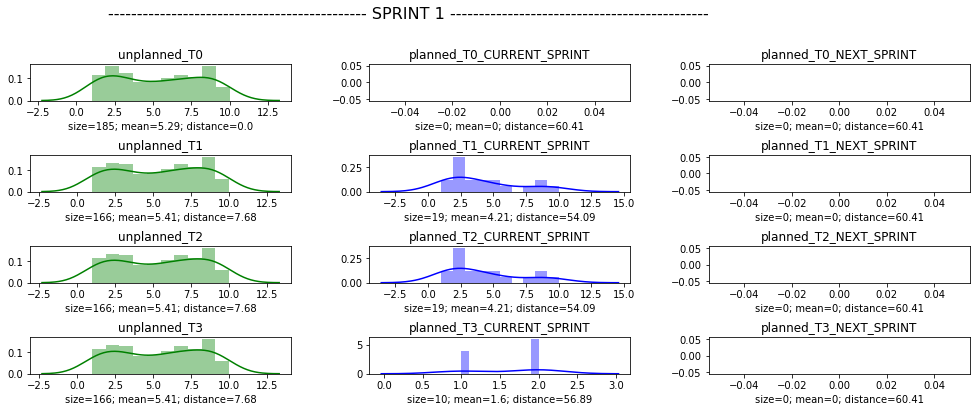

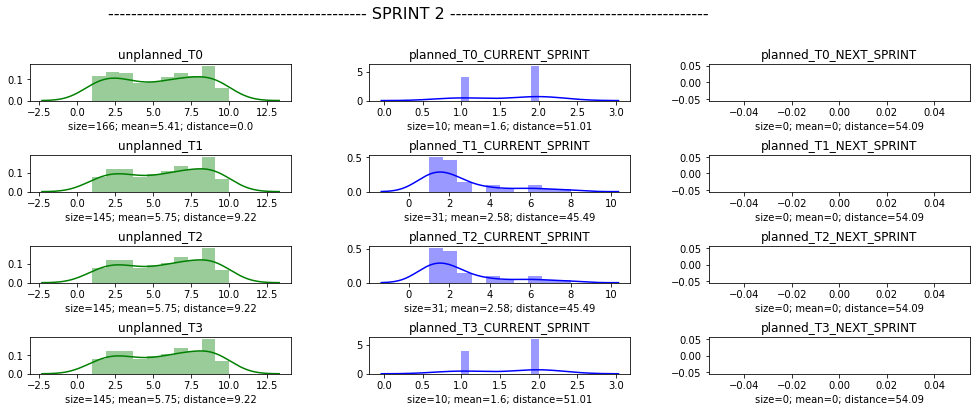

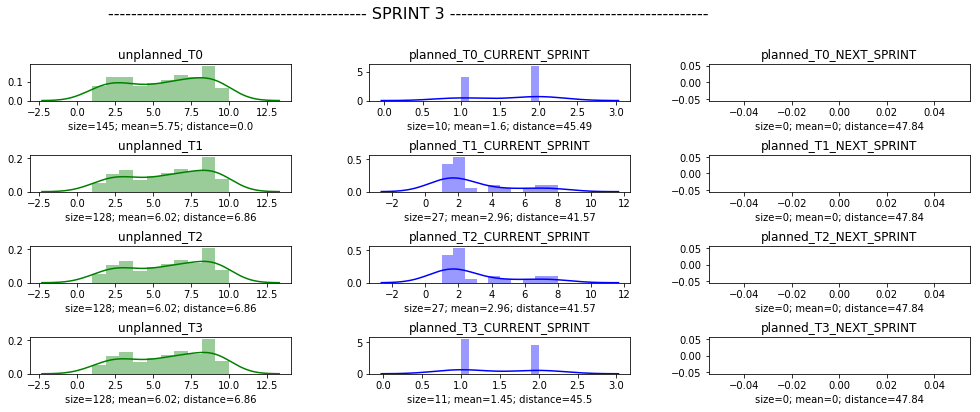

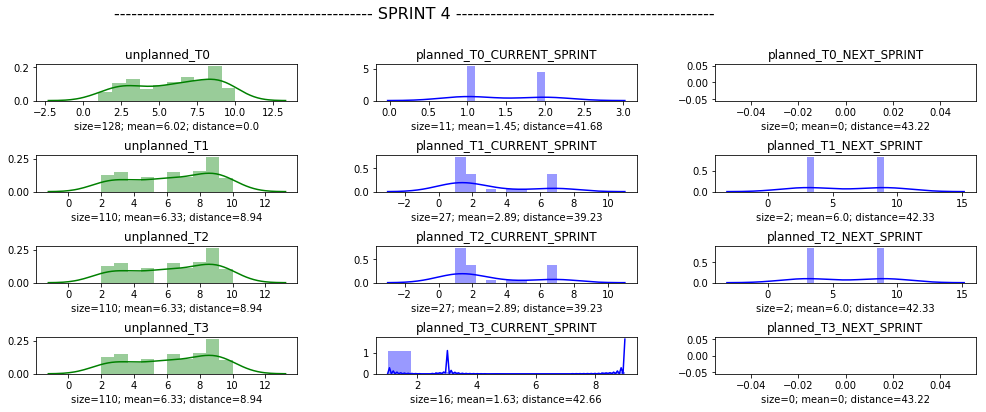

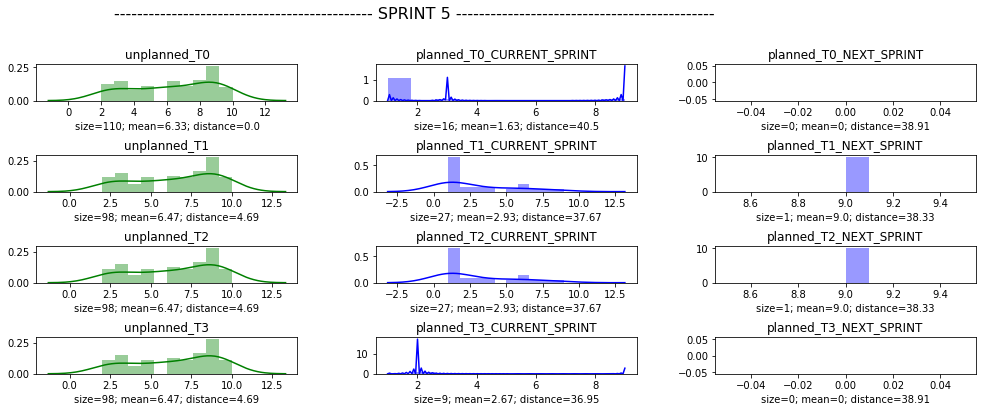

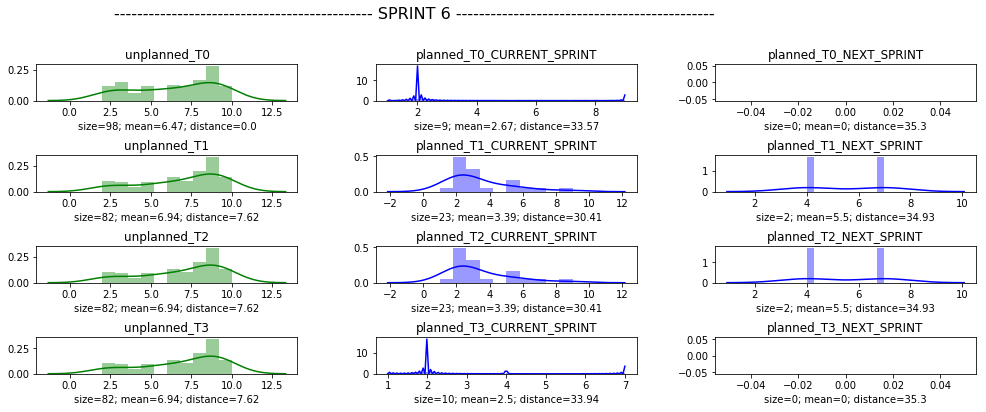

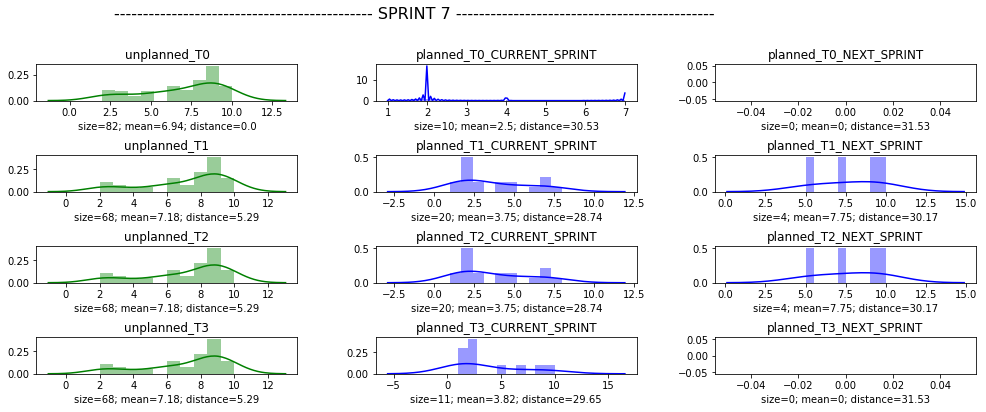

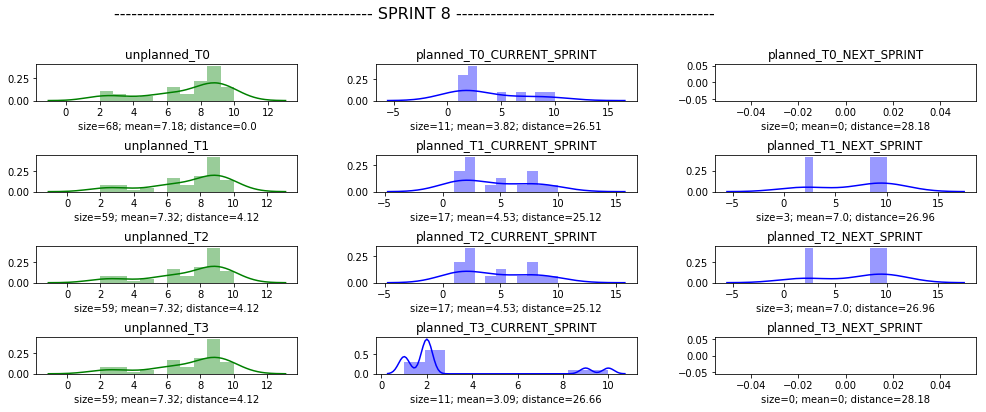

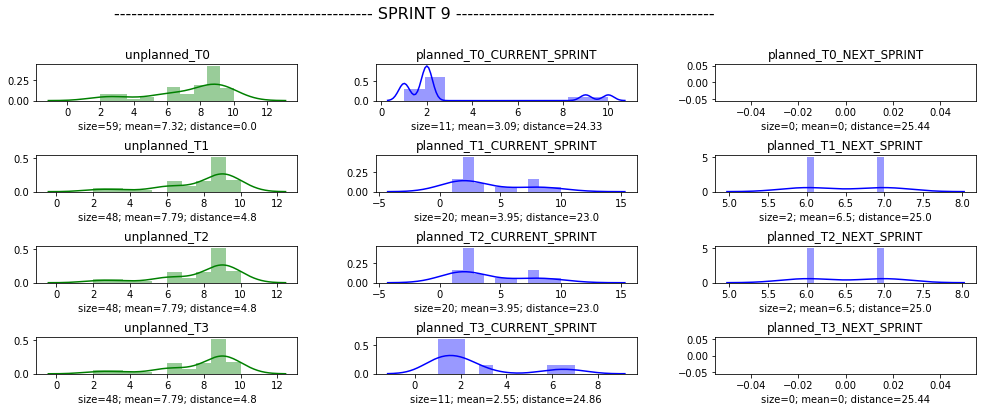

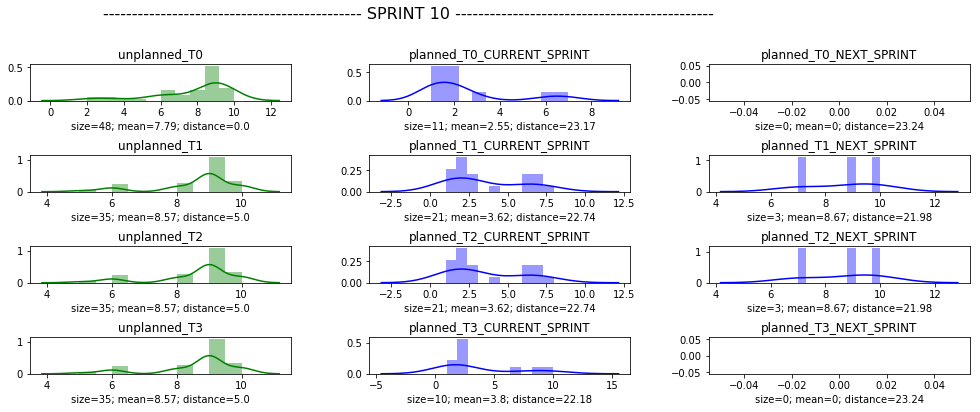

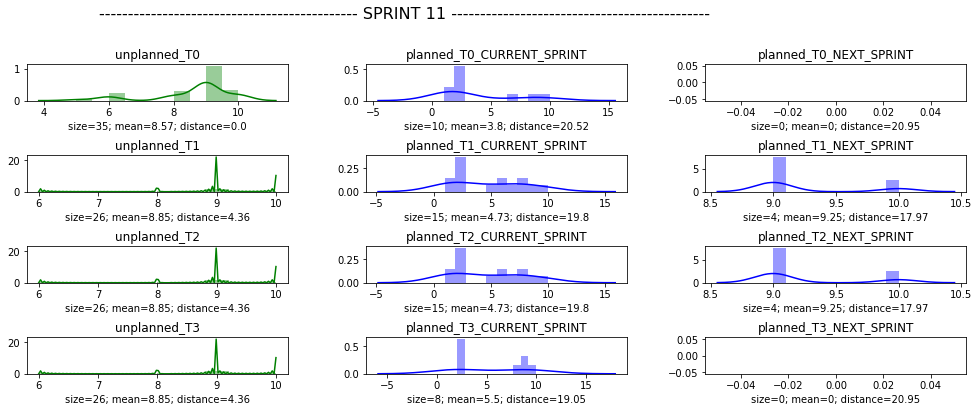

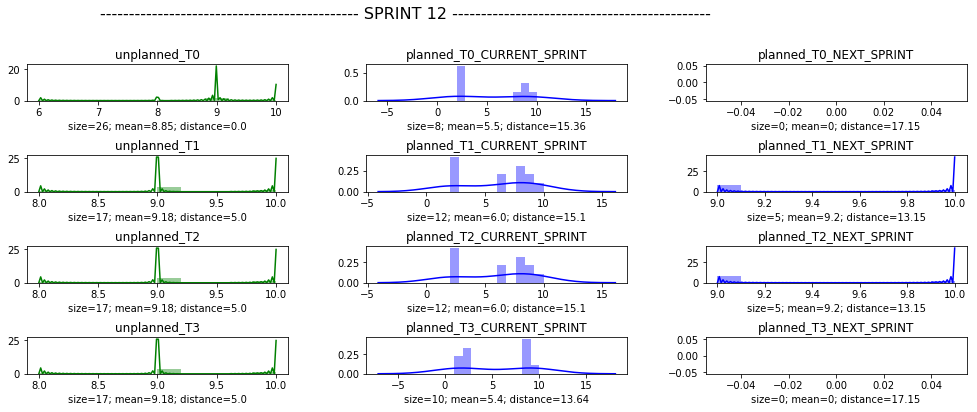

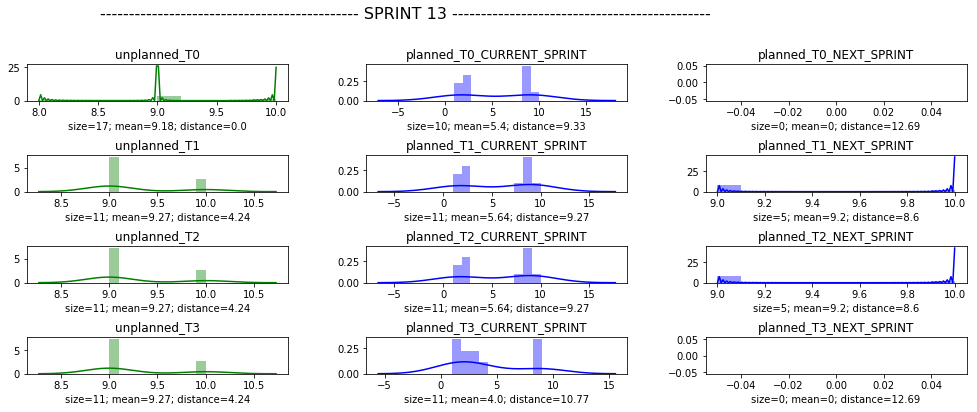

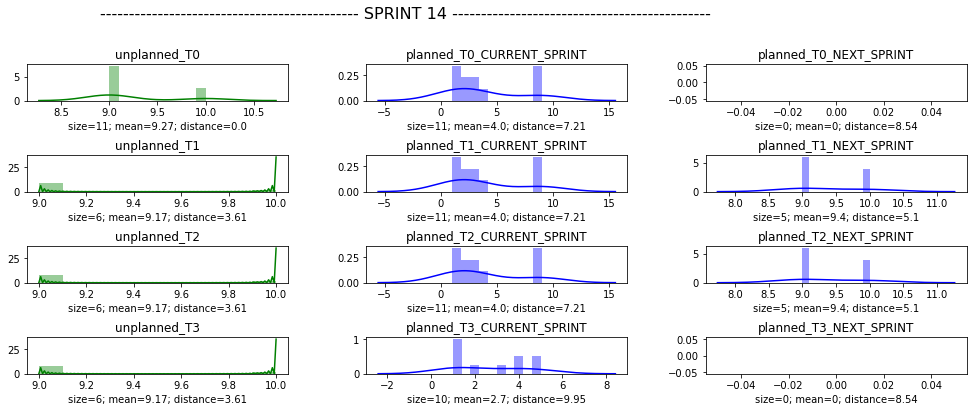

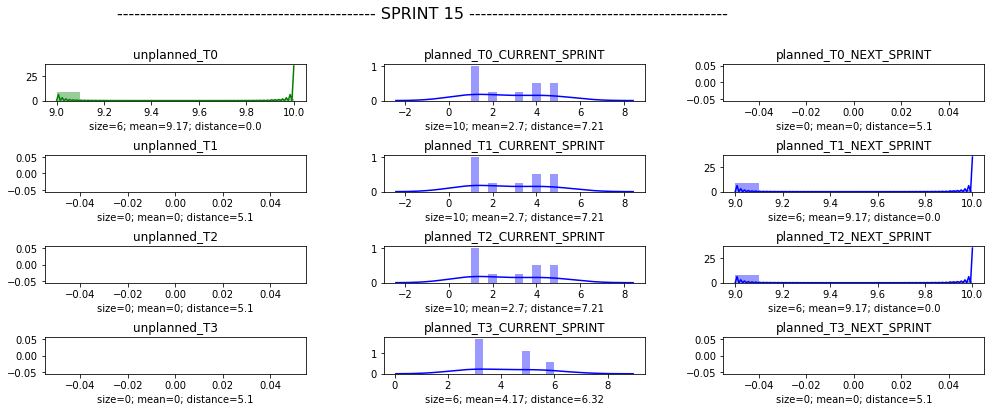

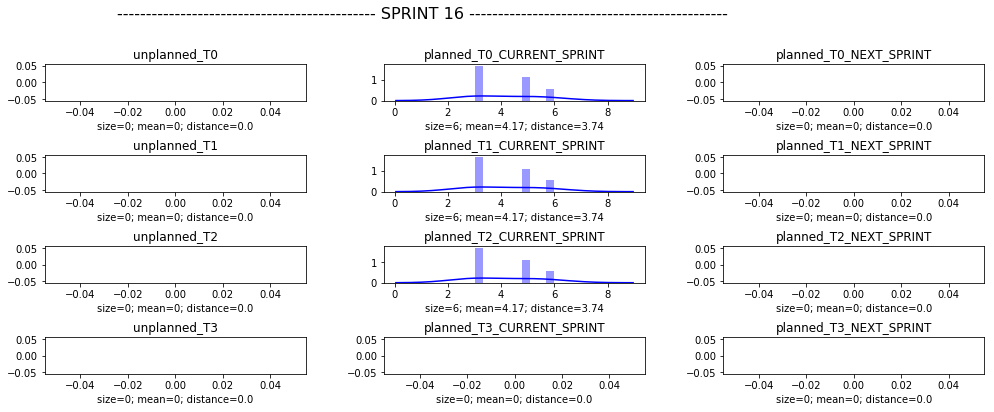

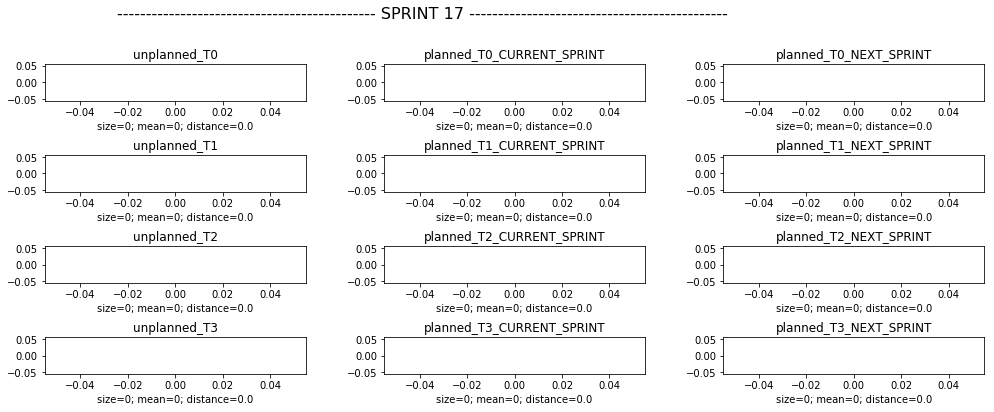

In [8]:
# Uncomment to interactively visualize the release logs, and then comment again once interactive analysis is done. Commenting these
# lines after interactive analysis is completed is required as test harness can't load these visualiations
# libraries so leaving this uncommented will crash the entire test harness.
# NB: MAY NEED TO RUN TWICE (there is a bug in Jupyter notebook, I think, so first call only shows warnings, not visuals)
#import devanalyst.simulation.visualizations.timecard_visuals as timecard_visuals
#timecard_visuals.renderReleaseCycleLog(teamId='Team A', release_log=test_releaseCycle_ACTUAL['log'], \
#                                       sprintDuration=10, first=1, last=17)


In [ ]:
test_releaseCycle_ACTUAL['Entries']

In [ ]:
test_releaseCycle_EXPECTED['Entries']

In [ ]:
test_releaseCycle_ACTUAL['Anton']

In [ ]:
test_releaseCycle_EXPECTED['Anton']

In [ ]:
test_releaseCycle_ACTUAL['Glenna']

In [ ]:
test_releaseCycle_EXPECTED['Glenna']

In [ ]:
test_releaseCycle_ACTUAL['Burnout']

In [ ]:
test_releaseCycle_EXPECTED['Burnout']

<h1>test_FOO: template for tests that produce a DataFrame output </h1>
<li> Copy to create a new test, and replace 'FOO' by the name of your test.
<li> Implement test logic in test_FOO()
<li> To create expected output once test logic is producing right output, temporarily uncomment the call to createExpectedOutput, call it, and comment it again. This saves expected output as a CSV file so subsequent runs of the test can load it and verify that the test still produces the same output as before.
<li> Uncomment lines that load expected output and remove the dummy line next to it creating a dummy expected output.
<li> Display the outputs for convenience in debugging when test fails.

In [ ]:
# Implement test logic, and run it

#Test logic
def test_FOO():
    output = {}
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10

    # Configure models
    modelsConfig = ModelsConfig([DefaultCostModel()], [], GreedyAllocationModel(SPRINT_DURATION)) 
    modelsConfig.random.reset(271)

    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)

    date1 = pd.Timestamp(2019,3,28)
    pubs1 = ['magazine', 'novel', 'textbook']
    date2 = pd.Timestamp(2019, 1,27)
    pubs2 = ['NY Times', 'The Atlantic', 'WSJ']
    dummyA_df = pd.DataFrame({'A': [45.123456789, 34.123456789], 'Date': [date1, date2], 'Publications': [pubs1, pubs2]})
    dummyB_df = pd.DataFrame({'B': [2333.123456789, 3984.123456789]})
    
    output['Dummy_A'] = dummyA_df
    output['Dummy_B'] = dummyB_df

    return output

# Run the test
test_FOO_ACTUAL = test_FOO()

In [ ]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_FOO_EXPECTED():
    tu_.createExpectedOutput(test_FOO_ACTUAL['Dummy_A'],    'test_FOO.Dummy_A')
    tu_.createExpectedOutput(test_FOO_ACTUAL['Dummy_B'],    'test_FOO.Dummy_B')

# Uncomment to update expected output to match the actual one, and then put the comment back
#create_FOO_EXPECTED()

In [ ]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
list_cols_A = ['Publications'] # Lists are loaded as strings, so require special processing on load
list_cols_B = []
test_FOO_EXPECTED = {}

test_FOO_EXPECTED['Dummy_A']      = tu_.loadExpectedOutput('test_FOO.Dummy_A', list_cols_A)
test_FOO_EXPECTED['Dummy_B']      = tu_.loadExpectedOutput('test_FOO.Dummy_B', list_cols_B)

# Rounding inaccuracies in saving and loading CSV will create an artificial mismatch between ACTUAL and EXPECTED
# So round EXPECTED and ACTUAL to 6 decimal places for sensitive fields (any float)
sensitive_fields = ['A']
testlets = ['Dummy_A']
for field in sensitive_fields:
    for testlet in testlets:
        rounded = test_FOO_EXPECTED[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_FOO_EXPECTED[testlet][field] = rounded
        rounded = test_FOO_ACTUAL[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_FOO_ACTUAL[testlet][field] = rounded
sensitive_fields = ['B']
testlets = ['Dummy_B']
for field in sensitive_fields:
    for testlet in testlets:
        rounded = test_FOO_EXPECTED[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_FOO_EXPECTED[testlet][field] = rounded
        rounded = test_FOO_ACTUAL[testlet][field].apply(lambda x: round(x, 6)) # Round to 6 decimal places
        test_FOO_ACTUAL[testlet][field] = rounded

# Dates are loaded as strings, not pd.Timestamps, so to avoid spurious mismatches between ACTUAL (which 
# represents dates as pd.Timestamps) and EXPECTED, convert the EXPECTED dates into pd.Timestamps
d = test_FOO_EXPECTED['Dummy_A']['Date']
test_FOO_EXPECTED['Dummy_A']['Date'] = d.apply(lambda x: pd.Timestamp(datetime.strptime(x, '%Y-%m-%d')))


tu_.EXPECTED['test_FOO.Dummy_A']        = test_FOO_EXPECTED['Dummy_A']
tu_.EXPECTED['test_FOO.Dummy_B']        = test_FOO_EXPECTED['Dummy_B']

tu_.ACTUAL['test_FOO.Dummy_A']          = test_FOO_ACTUAL['Dummy_A']
tu_.ACTUAL['test_FOO.Dummy_B']          = test_FOO_ACTUAL['Dummy_B']

tu_.testOK('test_FOO.Dummy_A'), \
tu_.testOK('test_FOO.Dummy_B'), \

In [ ]:
test_FOO_ACTUAL['Dummy_A']

In [ ]:
test_FOO_EXPECTED['Dummy_A']

In [ ]:
test_FOO_ACTUAL['Dummy_B']

In [ ]:
test_FOO_EXPECTED['Dummy_B']

<h1>Run all the tests in this notebook</h1>

In [ ]:
# Uncomment to run all the tests defined in this notebook
#unittest.main(argv=[''], verbosity=2, exit=False)